## PCA

#### 先看几个概念

[直观理解协方差](https://zhuanlan.zhihu.com/p/37609917)

In [1]:
import numpy as np
inp = np.array([[149.5,162.5,162.7,162.2,156.5,156.1,172.0,173.2,159.5,157.7],[69.5,77.0,78.5,87.5,74.5,74.5,76.5,81.5,74.5,79.0],[38.5,55.5,50.8,65.5,49.0,45.5,51.0,59.5,43.5,53.5]])

In [2]:
inp.shape

(3, 10)

In [3]:
# 求样本的均值和样本协方差矩阵

In [4]:
avg = np.average(inp, axis=1)

In [5]:
avg

array([161.19,  77.3 ,  51.23])

方差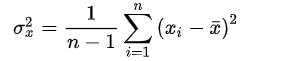
协方差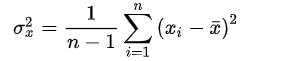

### 协方差

In [7]:
# 为了清晰地看出协方差矩阵是怎么得到的，定义一个函数
def cov_func(inp):
    # 
    ndim = inp.shape   # ndim = 3, 10
    batch = ndim[1]   # batch = 10
    V_dim = ndim[0]  # v_dim = 3
    cov_matrix= np.zeros((V_dim, V_dim))  # 3 X 3
    # 均值
    x_avg = np.average(inp, axis=1)  # 按行取均值
    mid_avg = (inp- x_avg.reshape(-1,1))  # 
    #print(mid_avg.shape)
    # 
    for i in range(V_dim):
        for j in range(V_dim):
            cov_matrix[i, j] = np.sum(np.multiply(mid_avg[i,:], mid_avg[j,:])) / (batch -1)
    return cov_matrix

In [8]:
cov_func(inp)

array([[51.74544444, 18.98666667, 34.41922222],
       [18.98666667, 23.45555556, 36.19555556],
       [34.41922222, 36.19555556, 61.69566667]])

* 根据系数矩阵，求解特征值和特征向量

In [21]:
def features(mat):
    # mat is a matrix
    X = mat
    # eigenvalue is 特征值；featurevector is 特征向量
    eigenvalue,featurevector=np.linalg.eig(X)
    F1 = featurevector[np.argmax(eigenvalue),:]
    print("特征值：{}\n".format(eigenvalue))
    print("特征向量：\n{}\n".format(featurevector))
    #return F1

In [22]:
features(cov_func(inp))

特征值：[110.00413886  25.32447973   1.56804807]

特征向量：
[[ 0.55915657  0.82767368 -0.04796048]
 [ 0.42128705 -0.33348264 -0.84338992]
 [ 0.71404562 -0.45138188  0.53515721]]



### 多维指标考虑的场景

#### 1 考虑主成分的贡献

In [31]:
lab = [110.00413886 ,25.32447973,  1.56804807]
print("贡献率：{}".format([x / np.sum(lab) for x in lab]))

贡献率：[0.8035560071978162, 0.18498974699578707, 0.011454245806396758]


#### 2 主成分个数的选取原则

* 根据贡献率的大小取前面m个（m< p），选取原则：

$$ \frac{\sum_{i=1}^{m-1}\lambda_i}{\sum_{i=1}^{p}\lambda_i} < 80 - 85\% $$ &
$$ \frac{\sum_{i=1}^{m}\lambda_i}{\sum_{i=1}^{p}\lambda_i} >= 80 - 85\% $$

#### 3 R型分析

> 为消除量纲的影响，在计算之前先将原始数据标准化。标准化变量S=R。所以标准化变量进行主成分分析相当于从原变量的相关矩阵R触发进行主成分分析。统计学上称这种方法为R型分析。由协方差矩阵出发的主成分分析为S型分析。

> Q: R型分析的主成分分析与S型有何不同？  
R型分析需要做一步标准化向量的操作。

## 从PCA到Sentences Vector

In [33]:
#### 引言 协方差有什么作用？

Stanford S2V 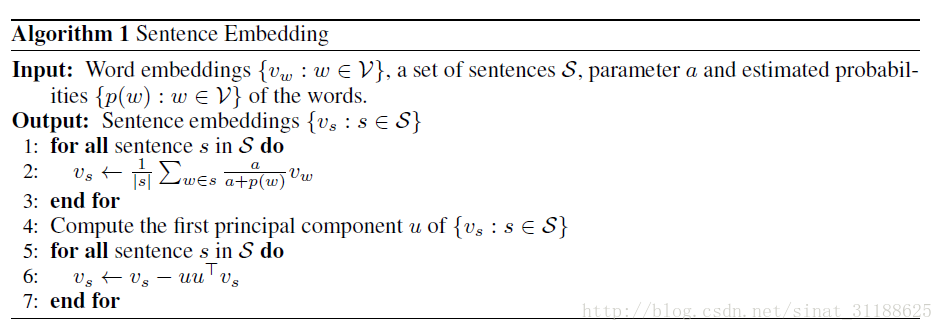

In [3]:
from gensim.models import KeyedVectors
import pickle as pkl
import numpy as np
from typing import List
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import os

In [4]:
from gensim.models import KeyedVectors
wordvec = KeyedVectors.load_word2vec_format(wordvecPath)

In [5]:
wordvec.distance("中国",'美国')

0.7561869770288467

In [6]:
def get_word_frequency(word_text, looktable):
    if word_text in looktable:
        return looktable[word_text]
    else:
        return 1.0

In [8]:
# 词、句、章都有自己的属性
class Word:
    def __init__(self, text, vector):
        self.text = text
        self.vector = vector


class Sentence:
    def __init__(self, word_list):
        self.word_list = word_list

    def len(self) -> int:
        return len(self.word_list)
    
class Document:
    def __init__(self, sentence_list):
        self.sentence_list = sentence_list
    
    def len(self) -> int:
        return len(sel.sentence_list)


In [9]:
def sentence_to_vec(sentence_list: List[Sentence], embedding_size, looktable, a=1e-3):
    sentence_set = []
    for sentence in sentence_list:
        vs = np.zeros(embedding_size)  # add all word2vec values into one vector for the sentence
        sentence_length = sentence.len()
        for word in sentence.word_list:
            a_value = a / (a + get_word_frequency(word.text, looktable))  # smooth inverse frequency, SIF
            vs = np.add(vs, np.multiply(a_value, word.vector))  # vs += sif * word_vector

        vs = np.divide(vs, sentence_length)  # weighted average
        sentence_set.append(vs)  # add to our existing re-calculated set of sentences

    # calculate PCA of this sentence set
    pca = PCA(n_components=embedding_size)
    pca.fit(np.array(sentence_set))
    u = pca.components_[0]  # the PCA vector
    u = np.multiply(u, np.transpose(u))  # u x uT

    # pad the vector?  (occurs if we have less sentences than embeddings_size)
    if len(u) < embedding_size:
        for i in range(embedding_size - len(u)):
            u = np.append(u, 0)  # add needed extension for multiplication below

    # resulting sentence vectors, vs = vs -u x uT x vs
    sentence_vecs = []
    for vs in sentence_set:
        sub = np.multiply(u, vs)
        sentence_vecs.append(np.subtract(vs, sub))

    return sentence_vecs


In [1]:
freqpath = "D:\AI\第4课\wikiextractor-master\wikiextractor-master\zhwiki\AA\wiki_zh_0"
#text = []
with open(freqpath + str(0), 'r', encoding='utf-8') as f:
    text = f.read()

In [5]:
text[0:100]

'<doc id="13" url="https://zh.wikipedia.org/wiki?curid=13" title="数学">\n数学\n\n数学是利用符号语言研究数量、结构、变化以及空间等概念'

In [6]:
import re, jieba

In [11]:
' '.join(re.findall(r'[\d|\w]+', text[:1000]))

'doc id 13 url https zh wikipedia org wiki curid 13 title 数学 数学 数学是利用符号语言研究数量 结构 变化以及空间等概念的一门学科 从某种角度看属于形式科学的一种 数学透过抽象化和逻辑推理的使用 由计数 计算 量度和对物体形状及运动的观察而产生 数学家们拓展这些概念 为了公式化新的猜想以及从选定的公理及定义中建立起严谨推导出的定理 基础数学的知识与运用总是个人与团体生活中不可或缺的一环 对数学基本概念的完善 早在古埃及 美索不达米亚及古印度内的古代数学文本便可观见 而在古希腊那里有更为严谨的处理 从那时开始 数学的发展便持续不断地小幅进展 至16世纪的文艺复兴时期 因为新的科学发现和数学革新两者的交互 致使数学的加速发展 直至今日 数学并成为许多国家及地区的教育范畴中的一部分 今日 数学使用在不同的领域中 包括科学 工程 医学 经济学和金融学等 数学对这些领域的应用通常被称为应用数学 有时亦会激起新的数学发现 并导致全新学科的发展 例如物理学的实质性发展中建立的某些理论激发数学家对于某些问题的不同角度的思考 数学家也研究纯数学 就是数学本身的实质性内容 而不以任何实际应用为目标 虽然许多研究以纯数学开始 但其过程中也发现许多应用之处 西方语言中 数学 一词源自于古希腊语的 其有 学习 学问 科学 以及另外还有个较狭义且技术性的意思 数学研究 即使在其语源内 其形容词 意思为 和学习有关的 或 用功的 亦会被用来指 数学的 其在英语中表面上的复数形式 及在法语中的表面复数形式 可溯至拉丁文的中性复数 由西塞罗译自希腊文复数 此一希腊语被亚里士多德拿来指 万物皆数 的概念 汉字表示的 数学 一词大约产生于中国宋元时期 多指象数之学 但有时也含有今天上的数学意义 例如 秦九韶的 数学九章 永乐大典 记 即 数书九章 也被宋代周密所著的 癸辛杂识 记为 数学大略 数学通轨 明代柯尚迁著 数学钥 清代杜知耕著 数学拾遗 清代丁取忠撰 直到1939年 经过中国数学名词审查委员会研究 算学 与 数学 两词的使用状况后 确认以 数学 表示今天意义上的数学含义 数学有着久远的历史 它被认为起源于人类早期的生产活动 中国古代'

In [12]:
content = ' '.join(re.findall(r'[\d|\w]+', text))

In [16]:
len(content)

195805092

In [17]:
content = content.split()

In [18]:
len(content)

20904338

In [21]:
content = [' '.join(jieba.cut(n, cut_all=False)) for n in content]

In [22]:
len(content)

20904338